In [ ]:
# DETECTION OF CONTEXT DECAY OR CHANGE IN THE TEXT

In [ ]:
!pip install transformers pandas datasets torch scikit-learn
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 1.6 MB/s eta 0:00:00


In [ ]:
from huggingface_hub import login
tok = ''
login(token=tok)

In [ ]:
import numpy as np
from scipy.stats import entropy
from scipy.spatial.distance import jensenshannon
from sentence_transformers import SentenceTransformer
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import re

In [ ]:
# Collect and merge multiple csv,excel files into single dataframe
def combine_multiple_files(files_dir_path):
  combined_files = pd.DataFrame()
  for files in os.listdir(files_dir_path):
    if files.endswith('.csv'):
      f_path = os.path.join(files_dir_path,files)
      df = pd.read_csv(f_path)
      combined_files = pd.concat([combined_files,df])
    elif files.endswith('.xlsx'):
      f_path = os.path.join(files_dir_path,files)
      df = pd.read_excel(f_path)
      combined_files = pd.concat([combined_files,df])
  return combined_files

In [ ]:

# Step 1: Generate sentence embeddings
sentences = [
    "The sun is shining brightly today.",
    "It's a perfect day for a picnic.",
    "Quantum mechanics is a fascinating field of study.",
    "The theory of relativity transformed modern physics."
]

# Load Sentence Transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')  # Choose any SentenceTransformer model
embeddings = model.encode(sentences)
print(embeddings.shape)
# Step 2: Convert embeddings to probability distributions
def to_probability_distribution(embedding, method='softmax'):
    """Convert an embedding vector into a probability distribution."""
    if method == 'softmax':
        exp_embedding = np.exp(embedding - np.max(embedding))  # Avoid overflow
        return exp_embedding / np.sum(exp_embedding)
    elif method == 'normalize':
        return np.abs(embedding) / np.sum(np.abs(embedding))
    else:
        raise ValueError("Invalid method. Choose 'softmax' or 'normalize'.")

# Convert embeddings to probabilities
distributions = [to_probability_distribution(embedding, method='softmax') for embedding in embeddings]

# Step 3: Compute KL divergence between consecutive distributions
kl_divergences = []
for i in range(len(distributions) - 1):
    P = distributions[i]
    Q = distributions[i + 1]
    kl_div = entropy(P, Q)  # KL divergence
    kl_divergences.append(kl_div)

# Step 4: Interpret results
for i, kl_div in enumerate(kl_divergences):
    print(f"KL divergence between sentence {i+1} and {i+2}: {kl_div:.4f}")
    if kl_div > 0.5:  # Threshold for significant context change
        print(f"--> Significant context change detected between sentence {i+1} and sentence {i+2}.")
    else:
        print(f"--> Sentences {i+1} and {i+2} are coherent.")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

(4, 384)
KL divergence between sentence 1 and 2: 0.0016
--> Sentences 1 and 2 are coherent.
KL divergence between sentence 2 and 3: 0.0025
--> Sentences 2 and 3 are coherent.
KL divergence between sentence 3 and 4: 0.0015
--> Sentences 3 and 4 are coherent.


In [ ]:


def text_splitter(text,split_pattern=None):
  if split_pattern is None:
      split_pattern = r'(?<=[.!?;:])\s+'
  sentences = re.split(split_pattern, text)
  return sentences

def clean_text(text):
    # Replace multiple spaces with a single space
    if isinstance(text, str):
      text = text.replace("\n", " ")
      text = " ".join(text.split())
    elif isinstance(text, (list | tuple)):
      text = [ " ".join(sentence.replace("\n", " ").split()) for sentence in text]
    return text

def remove_stopwords(text):
    # Regular expression to match sentences ending with '?'
    pattern = r'[^.?!:]*\?'
    # Remove matching sentences
    if isinstance(text, str):
      result = re.sub(pattern, '', text)
      # Remove any leading/trailing whitespace
      return result.strip()

    elif isinstance(text, (list | tuple)):
      result = [re.sub(pattern, '', sentence).strip() for sentence in text]
      return result

# Function: Load sentences from a text file (or use predefined list)
def load_sentences(file_path=None, text=None):

    if file_path is None and text is None:
        raise ValueError("Either 'file_path' or 'text' must be provided.")

    if file_path:
        with open(file_path, 'r') as file:
            sentences = [line.strip() for line in file if line.strip()]
            return sentences
    elif text is not None and isinstance(text,str):
        return text_splitter(text)
    elif text is not None and isinstance(text,list):
        return text
    else:
        raise ValueError("Invalid input. 'text' must be a string or a list of strings.")


def count_words_in_sentence(sentence,filter_sym=['?','.','!',':'],return_list=False):
  if isinstance(sentence,str):
      words_list =  sentence.split()
      n_words = len([word for word in words_list if word not in filter_sym])
      return n_words

  elif isinstance(sentence, list):
    n_words_list = []
    for sen in sentence:
      words_list =  sen.split()
      n_words = len([word for word in words_list if word not in filter_sym])
      n_words_list.append(n_words)

    if not return_list:
      return n_words_list[-1]
    return n_words_list

def one_and_zero_line_overlap_sentences(text_line_data,n_line_gap=2):
  data_keys = list(text_line_data.keys())
  l_dict = len(data_keys)
  overlap_seq = list(range(0,l_dict + 1,n_line_gap))
  text_line_data_keys = [data_keys[i] for i in overlap_seq if i < l_dict]
  overlapped_data = {k:text_line_data[k] for k in text_line_data_keys}
  return overlapped_data


def arrange_sentences(text_list, text_id=0, sliding_window=3):
  if sliding_window < 3 or sliding_window %2 ==0:
    raise ValueError('Sliding window must be odd integer and minimum value of 3')
  arranged_text_dict = {}
  n_sentences = len(text_list)
  global_text = ' '.join(text_list)

  # combine all text to single text and add key for document ID
  arranged_text_dict['global_text'] = global_text

  n_adjacent_sentences = int(sliding_window/2)

  MINIMUM_WORDS_PER_SENTENCE = 4
  critical_sentence_add_index_by = 1
  cum_sentence_and_masked_sentence = {}
  rev_cum_sentence_and_masked_sentence = {}
  slided_sentences = {}

  for i in range(n_sentences):

    ith_sentence = text_list[i]
    cummulative_sentences = text_list[:i]
    cum_sentence_and_masked = [' '.join(cummulative_sentences),text_list[i]]
    if cum_sentence_and_masked[0] != '' and cum_sentence_and_masked[1] != '':
        cum_sentence_and_masked_sentence[i] = cum_sentence_and_masked

    rev_cummulative_sentences = text_list[i+1:]
    rev_cum_sentence_and_masked = [text_list[i], ' '.join(rev_cummulative_sentences)]
    if rev_cum_sentence_and_masked[0] != '' and rev_cum_sentence_and_masked[1] != '':
        rev_cum_sentence_and_masked_sentence[i] = rev_cum_sentence_and_masked

    if  n_adjacent_sentences < i + 1 <  n_sentences:
      temp_sentences = []
      left_windowed_sentences = text_list[i - n_adjacent_sentences:i]
      left_sentence_n_words = count_words_in_sentence(left_windowed_sentences)

      if left_sentence_n_words < MINIMUM_WORDS_PER_SENTENCE and (i - n_adjacent_sentences - critical_sentence_add_index_by) >= 0:
        left_windowed_sentences = text_list[i - n_adjacent_sentences - critical_sentence_add_index_by:i]
      if left_windowed_sentences != []:
        temp_sentences.extend(left_windowed_sentences)

      # right windowed sentences
      right_windowed_sentences = text_list[i:i + n_adjacent_sentences + 1]
      right_sentence_n_words = count_words_in_sentence(right_windowed_sentences)

      if right_sentence_n_words < MINIMUM_WORDS_PER_SENTENCE and (i + n_adjacent_sentences + critical_sentence_add_index_by) <= n_sentences:
        right_windowed_sentences = text_list[i:i + n_adjacent_sentences + critical_sentence_add_index_by + 1]
      if right_windowed_sentences != []:
        temp_sentences.extend(right_windowed_sentences)

      # combined windowed sentences
      if temp_sentences != []:
        slided_sentences[i] = ' '.join(temp_sentences)

  arranged_text_dict['cummulative_text'] = cum_sentence_and_masked_sentence
  arranged_text_dict['rev_cummulative_text'] = rev_cum_sentence_and_masked_sentence
  arranged_text_dict['slided_text'] = slided_sentences
  return arranged_text_dict,text_id

# Function: Convert embeddings to probability distributions
def to_probability_distribution(embedding, method='softmax'):
    if method == 'softmax':
        exp_embedding = np.exp(embedding - np.max(embedding))  # Avoid overflow
        return exp_embedding / np.sum(exp_embedding)
    elif method == 'normalize':
        return np.abs(embedding) / np.sum(np.abs(embedding))
    else:
        raise ValueError("Invalid method. Choose 'softmax' or 'normalize'.")


def compute_cosine_similarity(vec1, vec2):
    """
    Computes the cosine similarity between two PyTorch tensors.

    Args:
        vec1 (list or torch.Tensor): First vector.
        vec2 (list or torch.Tensor): Second vector.

    Returns:
        float: Cosine similarity value.
    """
    # Convert vectors to tensors if not already
    vec1 = torch.tensor(vec1, dtype=torch.float32)
    vec2 = torch.tensor(vec2, dtype=torch.float32)

    # Compute cosine similarity
    similarity = F.cosine_similarity(vec1.unsqueeze(0), vec2.unsqueeze(0))
    return similarity.item()

# Function: Compute KL divergence between consecutive embeddings
def compute_divergences(embedding_distributions, method='softmax', divergence='kl'):
    # distributions = [to_probability_distribution(embedding, method) for embedding in embeddings]
    _divergences = []
    l_distribution = len(embedding_distributions)
    for i in range(l_distribution - 1):
        P = embedding_distributions[i]
        Q = embedding_distributions[i + 1]

        if divergence == 'kl':
          kl_div = entropy(P, Q)  # KL divergence
          _divergences.append(kl_div)

        elif divergence == 'js':
          js_divergence = jensenshannon(Q, P, base=2)  # Jensen-Shannon Divergence
          _divergences.append(js_divergence)
        else:
          raise ValueError("Invalid divergence. Choose 'kl' or 'js'.")
    return _divergences

# Function: Visualize KL divergences
def plot_kl_divergences(kl_divergences, threshold):
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(kl_divergences) + 1), kl_divergences, marker='o', label="KL Divergence")
    plt.axhline(y=threshold, color='r', linestyle='--', label=f"Threshold = {threshold}")
    plt.title("KL Divergence Between Consecutive Sentences")
    plt.xlabel("Sentence Pair Index")
    plt.ylabel("KL Divergence")
    plt.legend()
    plt.show()

def compute_text_embeddings(sentences, model_name='all-MiniLM-L6-v2'):
    torch.manual_seed(42)  # Set random seed for reproducibility
    model = SentenceTransformer(model_name)
    model.eval()
    embeddings = model.encode(sentences, device='cpu')
    return embeddings

def compute_scores(text_key_val, div_score_types=['kl']):
  cosine_score = {}
  div_score = {}
  print('Input lines: ',text_key_val)
  key_list = list(text_key_val.keys())
  l_keys = len(key_list)

  for i,target_line_idx in enumerate(key_list):
    if i+1 == l_keys:
      break

    line1 = text_key_val.get(key_list[i])
    if isinstance(line1, (list | tuple)):
      line1 = line1[0]
      line2 = line1[1]
    else:
      line2 = text_key_val.get(key_list[i+1])

    print('line1: ',line1)
    print('line2: ',line2)
    sentence1_embeddings = compute_text_embeddings(line1)
    sentence2_embeddings = compute_text_embeddings(line2)
    # cosine
    cosine_score_val = compute_cosine_similarity(sentence1_embeddings, sentence2_embeddings)
    cosine_score[target_line_idx] = cosine_score_val
    print('cosine score: ',cosine_score_val)
    # divergence score
    embedding_prob1 = to_probability_distribution(sentence1_embeddings, method='softmax')
    embedding_prob2 = to_probability_distribution(sentence2_embeddings, method='softmax')
    for div in div_score_types:
        div_sc = compute_divergences([embedding_prob1, embedding_prob2], method='softmax', divergence=div)
        div_score[div+str(target_line_idx)] = np.sum(div_sc)
  return cosine_score, div_score

def get_top_k_min_max(arr, k, mode='max'):
    """
    Returns the top k maximum values from the array.

    Args:
        arr (numpy.ndarray): Input array.
        k (int): Number of maximum values to retrieve.

    Returns:
        numpy.ndarray: Top k maximum values.
    """
    # Use argsort to sort and retrieve top k indices in descending order
    if mode == 'max':
      return arr[np.argsort(arr)[-k:]][::-1]
    elif mode == 'min':
      return arr[np.argsort(arr)[:k]]
    else:
      raise ValueError("Invalid mode. Choose 'max' or 'min'.")

# Main Analysis Function
def detect_context_changes(embeddings, method='softmax', threshold=0.3):

    # Step 2: Compute KL divergences
    kl_divergences = compute_divergences(embeddings, method)

    # Step 3: Detect context changes
    print("\nContext Change Detection Results:")
    context_changes = []
    for i, kl_div in enumerate(kl_divergences):
        print(f"KL divergence between sentence {i+1} and {i+2}: {kl_div:.4f}")
        if kl_div > threshold:
            print(f"--> Significant context change detected between sentence {i+1} and {i+2}.")
            context_changes.append((i + 1, i + 2))
        else:
            print(f"--> Sentences {i+1} and {i+2} are coherent.")

    # Step 4: Plot results
    plot_kl_divergences(kl_divergences, threshold)

    # Step 5: Summary
    print("\nSummary of Context Changes:")
    if context_changes:
        for change in context_changes:
            print(f"Context change detected between sentence {change[0]} and sentence {change[1]}.")
    else:
        print("No significant context changes detected.")
    return kl_divergences



In [ ]:
sentences = ['he is tall? ',
            "The sun is shining brightly today.",
             'I m fine.',
            "It's a perfect day for a picnic.",
             'Wow its nice to have dinner',
             'Thanks for you kind response',
            "Quantum mechanics is a fascinating field of study.",
            "The theory of relativity transformed modern physics.",
             'Hello friends I am in Beautiful Nepal.'
            ]

In [ ]:
processes = '''
Canning involves sealing food in airtight containers and subjecting them to heat to kill microorganisms and enzymes that cause spoilage. This process preserves food for extended periods without refrigeration. It is commonly used for fruits, vegetables, soups, and sauces. The technique ensures safety and retains nutritional value.

Fermentation uses microorganisms like bacteria or yeast to convert sugars in food into acids, gases, or alcohol. This process enhances the flavor, texture, and nutritional profile of foods like yogurt, kimchi, and sourdough bread. It also acts as a natural preservative. Fermented foods are known for their probiotic benefits.
The process of risk assessment begins with the Risk Manager systematically identifying potential risks that could impact organizational objectives.
This includes analyzing data from past incidents, industry trends, and internal operations.
After identifying risks, the likelihood of each event occurring and its potential impact are evaluated in collaboration with department heads?
Drying removes moisture from food to inhibit the growth of bacteria, yeast, and mold. Traditional methods like sun drying or modern techniques like freeze-drying are used for fruits, herbs, and meats. The process extends shelf life while retaining the food's essential nutrients. It is a cost-effective and energy-efficient preservation method.

Pasteurization involves heating liquids such as milk, juice, or eggs to a specific temperature for a short time to kill harmful pathogens. This process maintains the product's nutritional quality while increasing its safety and shelf life. It is widely used in the dairy and beverage industries. Pasteurized products require refrigeration for storage.

Blanching briefly exposes vegetables or fruits to boiling water or steam, followed by rapid cooling in ice water. This process preserves color, texture, and nutrients while reducing enzyme activity that leads to spoilage. It is often used as a preparatory step before freezing or canning. Blanched foods maintain quality during long-term storage.
'''

In [ ]:
txt = '''
The process of risk assessment begins with the Risk Manager systematically identifying potential risks that could impact organizational objectives.
This includes analyzing data from past incidents, industry trends, and internal operations.
After identifying risks, the likelihood of each event occurring and its potential impact are evaluated in collaboration with department heads?
Mitigation strategies are then crafted, ensuring they align with the company’s internal policies and industry-specific regulations.   Auditors are engaged throughout the process to provide additional oversight and ensure compliance with established standards.
Quantum mechanics is a fascinating field of study. The theory of relativity transformed modern physics.
'''

In [ ]:
text = load_sentences(file_path=None, text=sentences)
# print(text)
cleaned_text = clean_text(text)
n_total_sentences = len(cleaned_text)
print(n_total_sentences)
# text_no_stopwords = remove_stopwords(cleaned_text)
# print(text_no_stopwords)

arr_texts, text_id = arrange_sentences(cleaned_text, text_id=0, sliding_window=3)
# print(arr_texts.keys())

global_text = arr_texts.get('global_text')
forward_cummulative_text = arr_texts.get('cummulative_text')
reverse_cummulative_text = arr_texts.get('rev_cummulative_text')
slided_text = arr_texts.get('slided_text')
one_common_text = one_and_zero_line_overlap_sentences(slided_text, n_line_gap=3)
zero_common_text = one_and_zero_line_overlap_sentences(slided_text, n_line_gap=4)

print(global_text);print('')
print(forward_cummulative_text);print('')
print(reverse_cummulative_text);print('')
print(slided_text);print('----------------------')
print(one_common_text);print('')
print(zero_common_text);print('')
print('')
cosine_score, div_score = compute_scores(one_common_text)
cosine_score = {key: (value if value >= 0 else 0.0) for key, value in cosine_score.items()}

9
he is tall? The sun is shining brightly today. I m fine. It's a perfect day for a picnic. Wow its nice to have dinner Thanks for you kind response Quantum mechanics is a fascinating field of study. The theory of relativity transformed modern physics. Hello friends I am in Beautiful Nepal.

{1: ['he is tall?', 'The sun is shining brightly today.'], 2: ['he is tall? The sun is shining brightly today.', 'I m fine.'], 3: ['he is tall? The sun is shining brightly today. I m fine.', "It's a perfect day for a picnic."], 4: ["he is tall? The sun is shining brightly today. I m fine. It's a perfect day for a picnic.", 'Wow its nice to have dinner'], 5: ["he is tall? The sun is shining brightly today. I m fine. It's a perfect day for a picnic. Wow its nice to have dinner", 'Thanks for you kind response'], 6: ["he is tall? The sun is shining brightly today. I m fine. It's a perfect day for a picnic. Wow its nice to have dinner Thanks for you kind response", 'Quantum mechanics is a fascinating fi

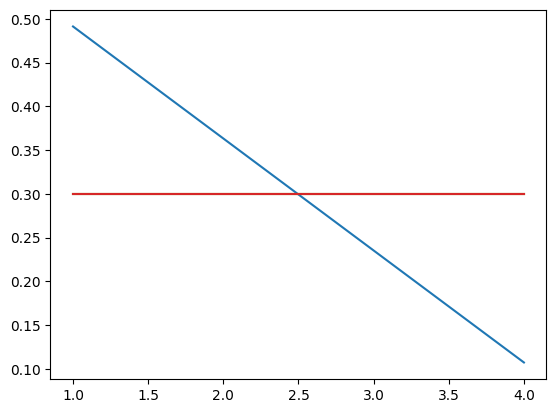

In [ ]:
x,y = list(map(int, cosine_score.keys())),list(cosine_score.values())

min_score = np.mean(get_top_k_min_max(np.array(y), 5, mode='min'))
max_score = np.mean(get_top_k_min_max(np.array(y), 5, mode='max'))
mean_ = np.mean(get_top_k_min_max(np.array(y), len(x), mode='max'))
plt.plot(x, y)
plt.plot(x, min_score * np.ones(len(x)))
plt.plot(x, max_score * np.ones(len(x)))
plt.plot(x, mean_ * np.ones(len(x)))
plt.show()

In [ ]:
emb_global = compute_text_embeddings(global_text)
emb_forward = compute_text_embeddings(list(forward_cummulative_text.values()))
embed_slided = compute_text_embeddings(list(slided_text.values()))


In [ ]:
yh = []
xc = []
for line, emb in enumerate(embed_slided):
  print('Line No: ',line+1)
  sc = compute_cosine_similarity(emb_global,emb)
  yh.append(sc)
  xc.append(line)
  print(sc)

Line No:  1
0.6350425481796265
Line No:  2
0.38062217831611633
Line No:  3
0.4042735993862152
Line No:  4
0.28684669733047485
Line No:  5
0.547161877155304
Line No:  6
0.5639004111289978
Line No:  7
0.6091894507408142


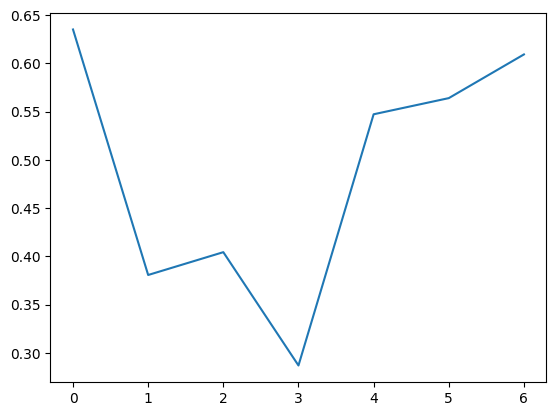

In [ ]:
plt.plot(xc, yh)
plt.show()

In [ ]:
cosine_score = {key:value for key, value in cosine_score.items() if value < mean_ and key > 1}
cosine_score

{4: 0.1071392297744751}

In [ ]:
line_idx = np.array(list(cosine_score.keys()))+1
print(line_idx)
for i,lines in  enumerate(cleaned_text):
    if i in line_idx:
      print('Line Number: ',i)
      print(cleaned_text[i])

[5]
Line Number:  5
Thanks for you kind response


In [ ]:
def score_deviation_ratio(target_score,previous_cum_score):
  diff = (target_score - previous_cum_score)
  if diff < 0:
    score_ = -1
  else:
    score_ = 1
  return np.round(abs(diff)/previous_cum_score,3),score_

Line and trancer:  [0, 0]
Score:  1.0
Line and trancer:  [1, 0]
Sliced Score:  1.0
Mean of score: 0.8024109601974487 and Score: 0.6048219203948975
var from mean:  0.24624419356626268
new context detected
The sun is shining brightly today.
Score:  0.6048219203948975
Line and trancer:  [2, 1]
Sliced Score:  0.6048219203948975
Mean of score: 0.606723427772522 and Score: 0.6086249351501465
var from mean:  0.003134059590554399
Score:  0.6086249351501465
Line and trancer:  [3, 1]
Sliced Score:  0.6086249351501465
Mean of score: 0.638970136642456 and Score: 0.6693153381347656
var from mean:  0.04749079769480623
Score:  0.6693153381347656
Line and trancer:  [4, 1]
Sliced Score:  0.6693153381347656
Mean of score: 0.6246875822544098 and Score: 0.580059826374054
var from mean:  0.07144012006657877
Score:  0.580059826374054
Line and trancer:  [5, 1]
Sliced Score:  0.580059826374054
Mean of score: 0.35209010541439056 and Score: 0.12412038445472717
var from mean:  0.647475511109168
new context detec

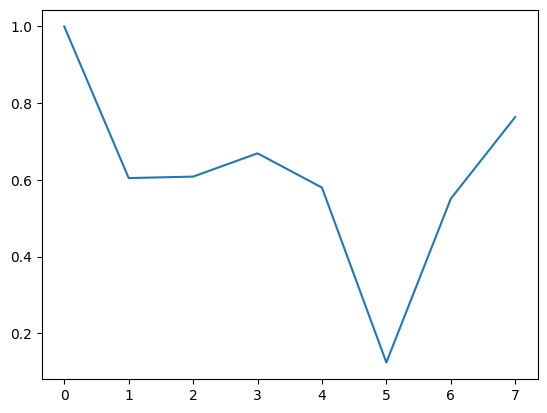

In [ ]:

yh = []
xc = []
line_tracer = 0
score_tracer = []
new_context_idx = []
threshold = 2
new_text = []
top_k_dev_score = {}
n_lines = len(cleaned_text)

for line, sentence in enumerate(cleaned_text):

  if line+1 < n_lines:
    print('Line and trancer: ',[line,line_tracer])

    cum_lines = ''.join(cleaned_text[line_tracer:line+1])
    target_line = cleaned_text[line]

    cum_embed = compute_text_embeddings(cum_lines)
    target_emb = compute_text_embeddings(target_line)

    sc = compute_cosine_similarity(cum_embed,target_emb)
    score_tracer.append(sc)
    if line > 0:
      print('Sliced Score: ',score_tracer[-2])
      me_an = np.mean(np.array(score_tracer[-2:]))
      print(f'Mean of score: {me_an} and Score: {sc}')
      var = abs(me_an - score_tracer[-1])
      per_ = var/me_an
      print('var from mean: ',per_)
      if per_ > 0.2:
        print('new context detected')
        print(sentence)
        new_context_idx.append(line)
        # new_text.append(cleaned_text[line_tracer:line+1])
        line_tracer = line
        # score_tracer = []
      else:
        # new_text.append(cleaned_text[line_tracer:line+1])
        pass

    new_text.append(cleaned_text[line_tracer:line+1])

    yh.append(sc)
    xc.append(line)
    print('Score: ',sc)

plt.plot(xc, yh)
plt.show()

In [ ]:
new_context_idx

[1, 5, 6]

In [ ]:
new_text

[['he is tall?'],
 ['The sun is shining brightly today.'],
 ['The sun is shining brightly today.', 'I m fine.'],
 ['The sun is shining brightly today.',
  'I m fine.',
  "It's a perfect day for a picnic."],
 ['The sun is shining brightly today.',
  'I m fine.',
  "It's a perfect day for a picnic.",
  'Wow its nice to have dinner'],
 ['Thanks for you kind response'],
 ['Quantum mechanics is a fascinating field of study.'],
 ['Quantum mechanics is a fascinating field of study.',
  'The theory of relativity transformed modern physics.']]

In [ ]:
top_ = 3
top_k_dev_score_list = sorted(list(top_k_dev_score.keys()),reverse=True)[:top_]
top_k_dev_lines = [top_k_dev_score[i] for i in top_k_dev_score_list]
top_k_dev_score_list,top_k_dev_lines

([], [])

In [ ]:
rev = sorted(top_k_dev_lines)
line_t = []
tracer = 0
for i in rev:
    ln = cleaned_text[tracer:i]
    line_t.append(ln)
    tracer = i
line_t

[]